# Gaussian Location Model

Notebook for the check of gradients

### Mount Drive

In [18]:
# mount my drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following path has to be adjusted if necessary:

In [19]:
%run "/content/drive/My Drive/Colab Notebooks/Utils.ipynb"
%run "/content/drive/My Drive/Colab Notebooks/Plot_fcts.ipynb"

### Imports

In [20]:
! pip install qmcpy --quiet

In [21]:
import numpy as np
import qmcpy

### Sampling

In [22]:
np.random.seed(111)

Set parameters:

In [23]:
m = 1500              # number of simulated samples
n = 1000              # number of true samples
theta = np.ones(2)    # true theta
d = len(theta)        # dimensions of data
p = d                 # dimensions of parameter space
s = 2                 # standard deviation of the model
l = -1                # lengthscale (l=-1 for median heuristic)

Define QMC sequence:

In [24]:
qmc = qmcpy.Halton(p)
qmc_1 = qmcpy.Halton(p+1) # for odd numbers of parameters

Sample from the Gaussian location model:

In [25]:
y = sample_gaussian('MC',m,d,s,theta)
x = sample_gaussian('MC',n,d,s,theta)

Plot the samples:

mean:  [1.0105, 0.9393]
sd:    [1.9784, 1.944]


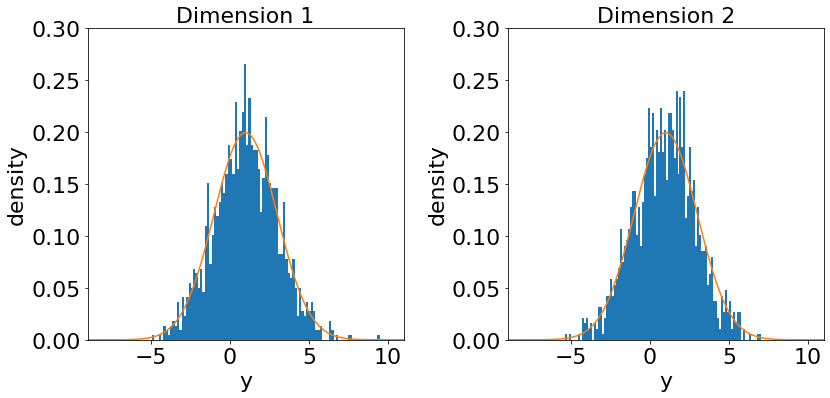

In [26]:
plot_gaussian(y,theta,d,s,cols=d,fig_size=(d*6,6))

### Check generator gradient

In [27]:
print('gradient of the generator:')
grad_gen_gaussian(n, theta)[:,:,0]

gradient of the generator:


array([[1., 0.],
       [0., 1.]])

### Check kernel

In [28]:
kxx = k(x,x,l)
kxy = k(x,y,l)
kyy = k(y,y,l)
k1xx = kxx[1]
k1xy = kxy[1]
k21xx = kxx[2]

In [29]:
print('kernel:')
print(kxy[0][1,1])
print('\nderivative w.r.t. the first element:')
print(kxy[1][:,1,1])
print('\nderivative w.r.t. the second and first element:')
print(kxy[2][:,:,1,1])

kernel:
1.1120007743085155e-05

derivative w.r.t. the first element:
[ 4.416e-05 -2.951e-05]

derivative w.r.t. the second and first element:
[[-1.643e-04  1.172e-04]
 [ 1.172e-04 -6.718e-05]]


In [30]:
#check derivatives using finite differences
print('check first derivative w.r.t. the first element:')
print((k(x+0.00000001,y,l)[0][1,1]-kxy[0][1,1])/0.00000001)
print(np.sum(kxy[1][:,1,1]))
print('\ncheck second derivative w.r.t. the second and first element:')
print((-k(x+0.00000001,y,l)[1][:,1,1]+kxy[1][:,1,1])/0.00000001)
print(np.sum(kxy[2][:,:,1,1],axis=0))

check first derivative w.r.t. the first element:
1.4655130441707052e-05
1.4655129619661427e-05

check second derivative w.r.t. the second and first element:
[-4.708e-05  5.001e-05]
[-4.708e-05  5.001e-05]


### Check the MMD$^2$ gradient $\hat{J}$

In [31]:
print('MMD^2 approximation:')
MMD_approx(n,m,kxx[0],kxy[0],kyy[0])

MMD^2 approximation:


-0.00019829860894650386

In [32]:
grad_g = grad_gen_gaussian(n, theta)
print('gradient of the MMD^2 approximation:')
grad_MMD(p,n,m,grad_g,k1xx,k1xy)

gradient of the MMD^2 approximation:


array([-0.001,  0.004])

In [33]:
# check gradient using finite differences
print('check gradient of the MMD^2 approximation:')
print((MMD_approx(n,m,k(x+0.00000001,x+0.00000001,l)[0],k(x+0.00000001,y,l)[0],kyy[0])-MMD_approx(n,m,kxx[0],kxy[0],kyy[0]))/0.00000001)
print(np.sum(grad_MMD(p,n,m,grad_g,k1xx,k1xy)))

check gradient of the MMD^2 approximation:
0.002692668310544377
0.002692659566659878


### Test information metric $g_U(\theta)$

In [34]:
# test function
print('approximation of information metric g:')
g_approx(p,n,grad_g,k21xx)

approximation of information metric g:


array([[ 0.013, -0.   ],
       [-0.   ,  0.013]])